In [56]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

# Data Input, EDA & Preprocessing

## Individual Data Input

In [2]:
price_vol = pd.read_csv('Price & Volume BTC.csv')
tweets = pd.read_csv('Tweets.csv')
funding_rates_1600 = pd.read_csv('Funding Rates BTCUSDT 1600.csv')
funding_rates_0800 = pd.read_csv('Funding Rates BTCUSDT 0800.csv')
funding_rates_0000 = pd.read_csv('Funding Rates BTCUSDT 0000.csv')
google = pd.read_csv('Google.csv')
transactions = pd.read_csv('Transactions.csv')
unique_addresses = pd.read_csv('Unique Addresses.csv')
active_addresses = pd.read_csv('../data/Active Addresses.csv')

## Data Compilation

In [3]:
# get daily ave value for twitter attributes
tweets = tweets.groupby(by="Time").mean()
tweets = tweets.reset_index()

df = pd.merge(price_vol, funding_rates_0000, on=['Time'])
df = pd.merge(df, funding_rates_0800, on=['Time'])
df = pd.merge(df, funding_rates_1600, on=['Time'])
df = pd.merge(df, google, on=['Time'])
df = pd.merge(df, active_addresses, on=['Time'])
df = pd.merge(df, unique_addresses, on=['Time'])
df = pd.merge(df, transactions, on=['Time'])
df = pd.merge(df, tweets, how="outer")
df.head()

,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2022-03-03,43896.8,42456.3,44088.0,41832.0,324545814.8,0.01%,0.01%,0.01%,13.84,24.08,1011448,701198.0,268244.0,443.269231,79.576923,0.109327,0.036269,0.063731,0.900000
1,2022-03-02,44428.2,43896.9,45367.5,43332.8,340460526.5,0.00%,0.00%,0.01%,15.61,26.33,1091796,731603.0,288657.0,534.200000,90.366667,0.068437,0.037100,0.068967,0.893967
2,2022-03-01,43174.8,44428.2,44966.0,42796.9,444858241.2,-0.01%,0.01%,0.01%,17.67,29.34,1065354,722863.0,280634.0,353.514286,61.028571,0.006329,0.062714,0.070200,0.867114
3,2022-02-28,37706.7,43179.8,44210.4,37446.5,564121052.5,0.00%,-0.02%,-0.01%,16.20,24.83,981066,702483.0,270918.0,332.333333,61.861111,0.135383,0.033806,0.073306,0.892861
4,2022-02-27,39117.3,37706.7,39864.0,36977.4,388368905.7,0.01%,0.01%,0.00%,12.96,21.07,768705,583361.0,211164.0,128.000000,30.000000,0.106867,0.022667,0.055000,0.922333


In [4]:
print("Type of variables: ", "\n", df.dtypes)

Type of variables:  
 Time                        object
Open                       float64
Close                      float64
High                       float64
Low                        float64
Volume                     float64
Funding Rate 0000           object
Funding Rate 0800           object
Funding Rate 1600           object
Bitcoin_SVI                float64
Cryptocurrency_SVI         float64
No. of Active Addresses      int64
No. of Unique Addresses    float64
Transactions               float64
Favorites                  float64
Retweets                   float64
Compound                   float64
Negative                   float64
Positive                   float64
Neutral                    float64
dtype: object


# Preprocessing

## Data Type Transformation

In [5]:
# Transform object type of "Funding Rate 0000", "Funding Rate 0800" and " Funding Rate 1600" to numerical type
df['Funding Rate 0000'] = df['Funding Rate 0000'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 0800'] = df['Funding Rate 0800'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 1600'] = df['Funding Rate 1600'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))

df['Month'] = df['Time'].str[:7]
df['Time2'] = df['Time'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['Month'] = df['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['FundingRate'] = (df['Funding Rate 1600'] + df['Funding Rate 0800'] + df['Funding Rate 0000'])/3 
df = df.sort_values(by = 'Time', ascending=True).reset_index(drop=True)
df.head(10)


,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,...,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral,Month,Time2,FundingRate
0,2020-03-04,8761.2,8750.7,8847.1,8655.7,1.221924e+07,0.01,0.01,0.01,8.64,...,358745.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200304,0.010000
1,2020-03-05,8750.8,9056.9,9153.1,8750.7,1.521845e+07,0.02,0.01,0.02,9.26,...,349529.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200305,0.016667
2,2020-03-06,9056.2,9134.3,9168.7,8989.1,8.833555e+06,0.02,0.02,0.02,8.95,...,338383.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200306,0.020000
3,2020-03-07,9133.9,8889.9,9184.9,8789.8,7.525135e+06,0.04,0.04,0.03,7.10,...,313312.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200307,0.036667
4,2020-03-08,8889.9,8036.5,8889.9,8001.1,1.439716e+07,0.03,0.05,0.05,8.02,...,302694.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200308,0.043333
5,2020-03-09,8035.0,7931.3,8175.2,7636.3,2.070482e+07,0.04,0.01,0.01,16.05,...,348211.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200309,0.020000
6,2020-03-10,7931.4,7895.3,8147.1,7736.9,1.365059e+07,0.01,0.01,0.01,12.34,...,329698.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200310,0.010000
7,2020-03-11,7895.4,7933.2,8000.0,7590.0,1.145017e+07,0.01,0.01,0.01,10.49,...,287492.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200311,0.010000
8,2020-03-12,7933.2,4802.9,7960.4,4448.6,5.524836e+07,0.02,0.01,0.01,22.83,...,349978.0,5.0,2.0,0.0772,0.091,0.1,0.809,202003,20200312,0.013333
9,2020-03-13,4811.8,5576.3,5950.0,3800.0,6.423345e+07,-0.02,-0.02,-0.30,30.86,...,276798.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200313,-0.113333


## Handle Missing Data

In [6]:
# Count missing value
print(df.isna().sum())

Time                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Funding Rate 0000            0
Funding Rate 0800            0
Funding Rate 1600            0
Bitcoin_SVI                  0
Cryptocurrency_SVI           0
No. of Active Addresses      0
No. of Unique Addresses      2
Transactions                 0
Favorites                  458
Retweets                   458
Compound                   458
Negative                   458
Positive                   458
Neutral                    458
Month                        0
Time2                        0
FundingRate                  0
dtype: int64


### Monthly Sentiment Analysis

In [7]:
tweets.insert(1, "Month", "NaN")

tweets['Month'] = tweets['Time'].str[:7]
tweets['Month'] = tweets['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
tweets.head(10)

,Time,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2020-03-12,202003,5.0,2.0,0.0772,0.091,0.100,0.809
1,2020-03-17,202003,98.0,96.0,0.4019,0.000,0.114,0.886
2,2020-03-20,202003,125.0,95.0,0.4767,0.000,0.146,0.854
3,2020-03-30,202003,3.0,0.0,0.0803,0.061,0.071,0.869
4,2020-03-31,202003,186.0,142.0,0.6597,0.000,0.278,0.722
5,2020-04-01,202004,171.0,120.0,0.5267,0.061,0.184,0.754
6,2020-04-16,202004,419.0,94.0,0.0000,0.000,0.000,1.000
7,2020-04-22,202004,73.0,18.0,0.3182,0.000,0.084,0.916
8,2020-04-30,202004,994.0,153.0,0.0000,0.000,0.000,1.000
9,2020-05-09,202005,35.0,2.0,0.0000,0.000,0.000,1.000


In [8]:
tweets = tweets.groupby(by="Month").mean()
tweets = tweets.reset_index()

In [9]:
tweets.head(10)

,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,202003,83.400000,67.000000,0.339160,0.030400,0.141800,0.828000
1,202004,414.250000,96.250000,0.211225,0.015250,0.067000,0.917500
2,202005,283.285714,49.142857,0.002414,0.027857,0.057429,0.914571
3,202006,232.000000,155.000000,0.401900,0.000000,0.072000,0.928000
4,202007,303.750000,79.000000,0.227450,0.000000,0.065250,0.934750
5,202008,1103.925926,241.740741,0.379407,0.016296,0.146444,0.837407
6,202009,63.500000,17.000000,0.121117,0.000000,0.035000,0.965000
7,202010,300.000000,50.000000,0.405267,0.000000,0.146000,0.854000
8,202011,254.666667,37.833333,0.117625,0.049250,0.123000,0.827750
9,202012,487.428571,56.571429,0.133693,0.058571,0.110143,0.831286


In [10]:
overall_df = pd.DataFrame(columns = ['Time', 'Month', 'Time2', 'Compound', \
                                 'Close', 'Volume', 'FundingRate', \
                             'Bitcoin_SVI', 'Cryptocurrency_SVI',  'No. of Active Addresses', \
                                 'No. of Unique Addresses', 'Transactions'])

for i, row in df.iterrows():
    if (pd.isna(df.loc[i].at["Favorites"])):
        data = tweets[tweets['Month'] == df.loc[i].at["Month"]]
        new_row = {'Time': df.loc[i].at["Time"],'Time2': df.loc[i].at["Time2"], 'Month': df.loc[i].at["Month"],  'Compound': data.Compound.values[0], \
                    
                 'Close': df.loc[i].at["Close"], 'Volume': df.loc[i].at["Volume"], 'FundingRate': df.loc[i].at["FundingRate"], \
                  'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)
    else:
        new_row = {'Time': df.loc[i].at["Time"], 'Time2': df.loc[i].at["Time2"],'Month': df.loc[i].at["Month"], 'Compound': df.loc[i].at["Compound"], \
                  
                 'Close': df.loc[i].at["Close"],'Volume': df.loc[i].at["Volume"], 'FundingRate': df.loc[i].at["FundingRate"], \
                  'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)


/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3212/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3212/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3212/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3212/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [11]:
overall_df = overall_df.drop(['Month'], axis = 1)
overall_df.head(10)

,Time,Time2,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,2020-03-04,20200304,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
1,2020-03-05,20200305,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
2,2020-03-06,20200306,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
3,2020-03-07,20200307,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
4,2020-03-08,20200308,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0
5,2020-03-09,20200309,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10,20200310,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11,20200311,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12,20200312,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13,20200313,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [12]:
from datetime import datetime

for i in range(len(overall_df)): 
    overall_df.loc[i, 'Time'] = datetime.strptime(overall_df.loc[i, 'Time'], '%Y-%m-%d')


In [13]:
overall_df.drop(columns=['Time2'], inplace=True)
overall_df.head(10)

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,2020-03-04 00:00:00,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
1,2020-03-05 00:00:00,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
2,2020-03-06 00:00:00,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
3,2020-03-07 00:00:00,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
4,2020-03-08 00:00:00,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0
5,2020-03-09 00:00:00,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10 00:00:00,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11 00:00:00,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12 00:00:00,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13 00:00:00,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [14]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [15]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

In [16]:
overall_df = get_mov_avg_std(overall_df, 'Close',N)

Text(0.5, 1.0, 'Price of BTC From 4th March 2020 to 3rd March 2022')

<Figure size 1440x720 with 0 Axes>

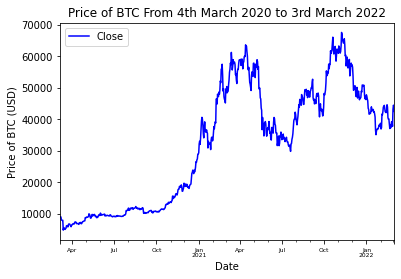

In [17]:
fig = plt.figure(figsize=(20,10))
ax  = overall_df.plot(x = 'Time',y = 'Close', style = 'b-')
plt.xlabel('Date')
plt.xticks(fontsize=6 ) 
plt.ylabel('Price of BTC (USD)')
plt.title("Price of BTC From 4th March 2020 to 3rd March 2022")

# Train-Test Split


In [18]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = overall_df[:num_train]
cv = overall_df[num_train:num_train+num_cv]
train_cv = overall_df[:num_train+num_cv]
test = overall_df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 438
num_cv = 146
num_test = 146
train.shape = (438, 12)
cv.shape = (146, 12)
train_cv.shape = (584, 12)
test.shape = (146, 12)


In [19]:
train_time = train['Time']
test_time = test['Time']
cv_time = cv['Time']
train_cv_time = train_cv['Time']

train = train.drop(columns = ['Time'])
test = test.drop(columns = ['Time'])
cv = cv.drop(columns = ['Time'])
train_cv = train_cv.drop(columns = ['Time'])

# Select features, the target output is'Close'
feature_pool = train.columns
#Note : Close is a feature as well 

output = 'Close'

In [20]:
print(feature_pool)

Index(['Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Close_mean', 'Close_std'],
      dtype='object')


### NaN Values

In [21]:
print(train.isna().sum())
print(test.isna().sum())
print(cv.isna().sum())
print(train_cv.isna().sum())

Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
Close_mean                 1
Close_std                  2
dtype: int64
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
Close_mean                 0
Close_std                  0
dtype: int64
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
Close_mean                 0
Close_std                  0
dtype: int64
Comp

In [22]:

train

,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Close_mean,Close_std
0,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0,NaN,NaN
1,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0,8750.700000,NaN
2,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0,8903.800000,216.516096
3,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0,8980.633333,202.853872
4,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0,9027.033333,124.907379
...,...,...,...,...,...,...,...,...,...,...,...
433,0.417171,56678.3,382931091.5,0.063333,21.24,60.19,1258920,854634.0,312115.0,57642.166667,1613.304343
434,0.417171,49661.9,522673294.3,0.026667,22.03,57.53,1245595,852846.0,300452.0,56913.900000,1235.464597
435,0.417171,49675.4,497271871.0,0.02,53.49,62.84,1187747,806882.0,276472.0,54051.133333,3825.719075
436,0.071533,49848.5,273449532.7,0.033333,33.04,52.22,1066269,752353.0,266055.0,52005.200000,4047.028944


In [23]:

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(train)
train = pd.DataFrame(KNN_miss_filling.transform(train))

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(test)
test = pd.DataFrame(KNN_miss_filling.transform(test))

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(train_cv)
train_cv = pd.DataFrame(KNN_miss_filling.transform(train_cv))

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(cv)
cv = pd.DataFrame(KNN_miss_filling.transform(cv))



In [24]:
train.columns = feature_pool
test.columns = feature_pool
train_cv.columns = feature_pool
cv.columns = feature_pool

In [25]:
print(train.isna().sum())
print(test.isna().sum())
print(cv.isna().sum())
print(train_cv.isna().sum())

Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
Close_mean                 0
Close_std                  0
dtype: int64
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
Close_mean                 0
Close_std                  0
dtype: int64
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
Close_mean                 0
Close_std                  0
dtype: int64
Comp

In [26]:
train

,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Close_mean,Close_std
0,0.339160,8750.7,1.221924e+07,0.010000,8.64,4.34,857423.0,625096.0,358745.0,8128.500000,54.525365
1,0.339160,9056.9,1.521845e+07,0.016667,9.26,3.76,793221.0,603996.0,349529.0,8750.700000,83.960633
2,0.339160,9134.3,8.833555e+06,0.020000,8.95,3.33,804945.0,601698.0,338383.0,8903.800000,216.516096
3,0.339160,8889.9,7.525135e+06,0.036667,7.10,3.04,682432.0,526880.0,313312.0,8980.633333,202.853872
4,0.339160,8036.5,1.439716e+07,0.043333,8.02,4.34,654911.0,501571.0,302694.0,9027.033333,124.907379
...,...,...,...,...,...,...,...,...,...,...,...
433,0.417171,56678.3,3.829311e+08,0.063333,21.24,60.19,1258920.0,854634.0,312115.0,57642.166667,1613.304343
434,0.417171,49661.9,5.226733e+08,0.026667,22.03,57.53,1245595.0,852846.0,300452.0,56913.900000,1235.464597
435,0.417171,49675.4,4.972719e+08,0.020000,53.49,62.84,1187747.0,806882.0,276472.0,54051.133333,3825.719075
436,0.071533,49848.5,2.734495e+08,0.033333,33.04,52.22,1066269.0,752353.0,266055.0,52005.200000,4047.028944


In [27]:
test.to_csv('test.csv', index=False)
train.to_csv('train.csv', index=False)
cv.to_csv('cv.csv', index=False)
train_cv.to_csv('train_cv.csv', index=False)

## Scale the train, dev and test set

In [95]:
# Standardized features:
standardized_features = ['Compound','Volume', 'Close', 'Close_mean', 'Close_std', 'Transactions', 'Cryptocurrency_SVI', 'Bitcoin_SVI','No. of Active Addresses', 'No. of Unique Addresses']     
non_standardized_features = list(set(train.columns)-set(standardized_features))

In [96]:
# Get the scaler based on train set
scaler = preprocessing.StandardScaler().fit(train[standardized_features])
print('The mean and variance of training set:', scaler.mean_, scaler.var_)

train_std=pd.DataFrame(scaler.fit_transform(train[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_nstd=pd.DataFrame(train[non_standardized_features])


train_std.columns = train_std.columns.map(lambda x: standardized_features[x])
train_std.reset_index(drop=True, inplace=True)
train_nstd.reset_index(drop=True, inplace=True)
train_scaled = pd.concat([train_std,train_nstd], sort=False,axis=1)

The mean and variance of training set: [2.41341098e-01 9.54626920e+07 2.30738331e+04 2.28920158e+04
 6.16252483e+02 3.04730473e+05 1.26245890e+01 1.23743151e+01
 9.93335228e+05 6.80755704e+05] [3.59572832e-02 1.30998447e+16 3.40708747e+08 3.38081201e+08
 6.06197476e+05 1.19213336e+09 2.17695327e+02 8.78085117e+01
 2.34354637e+10 1.04912459e+10]


In [97]:
train_scaled.head()

,Compound,Volume,Close,Close_mean,Close_std,Transactions,Cryptocurrency_SVI,Bitcoin_SVI,No. of Active Addresses,No. of Unique Addresses,FundingRate
0,0.515857,-0.727306,-0.775973,-0.802933,-0.721470,1.564401,-0.561496,-0.398513,-0.887814,-0.543410,0.010000
1,0.515857,-0.701101,-0.759384,-0.769094,-0.683664,1.297482,-0.600806,-0.332349,-1.307197,-0.749410,0.016667
2,0.515857,-0.756887,-0.755191,-0.760767,-0.513413,0.974665,-0.629949,-0.365431,-1.230613,-0.771846,0.020000
3,0.515857,-0.768319,-0.768431,-0.756589,-0.530960,0.248543,-0.649604,-0.562857,-2.030900,-1.502299,0.036667
4,0.515857,-0.708277,-0.814665,-0.754065,-0.631073,-0.058982,-0.561496,-0.464677,-2.210674,-1.749393,0.043333


In [98]:
# Get the scaler based on cv set
scaler.cv = preprocessing.StandardScaler().fit(cv[standardized_features])
print('The mean and variance of cv set:', scaler.cv.mean_, scaler.cv.var_)


cv_std=pd.DataFrame(scaler.transform(cv[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
cv_nstd=pd.DataFrame(cv[non_standardized_features])
cv_std.columns = cv_std.columns.map(lambda x: standardized_features[x])
cv_std.reset_index(drop=True, inplace=True)
cv_nstd.reset_index(drop=True, inplace=True)
cv_scaled = pd.concat([cv_std,cv_nstd], sort=False,axis=1)
cv_scaled.head()



The mean and variance of cv set: [3.28614978e-01 2.85925013e+08 4.08310986e+04 4.07511388e+04
 1.21745884e+03 2.34026877e+05 2.45351370e+01 1.66892466e+01
 8.66877952e+05 5.92385281e+05] [5.68894103e-02 1.56544096e+16 3.91950446e+07 3.61950437e+07
 5.61319637e+05 1.07050132e+09 1.04743798e+02 1.34344895e+02
 1.14164040e+10 5.07872054e+09]


,Compound,Volume,Close,Close_mean,Close_std,Transactions,Cryptocurrency_SVI,Bitcoin_SVI,No. of Active Addresses,No. of Unique Addresses,FundingRate
0,0.927255,3.028361,1.265207,1.407214,1.425922,-2.470379,3.007584,2.521251,-0.141660,-0.745925,0.026667
1,0.927255,3.674971,1.108708,1.348332,1.626690,-1.558781,2.736481,4.335432,-0.198262,0.034418,0.036667
2,1.674808,2.833219,1.071278,1.233943,1.490570,-2.424531,2.533153,2.948117,-0.892569,-0.600524,0.040000
3,0.927255,6.470709,0.736301,1.162740,1.647435,-1.196488,5.921949,9.351109,0.246996,0.527814,0.023333
4,0.686405,3.609817,0.945735,0.985754,4.069944,-2.221185,3.278688,7.110062,-0.324321,0.136979,-0.023333


In [99]:
scaler_traincv = preprocessing.StandardScaler().fit(train_cv[standardized_features])
print('The mean and variance of training cv set:', scaler_traincv.mean_, scaler_traincv.var_)


train_cv_std=pd.DataFrame(scaler.transform(train_cv[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_cv_nstd=pd.DataFrame(train_cv[non_standardized_features])
train_cv_std.columns = train_cv_std.columns.map(lambda x: standardized_features[x])
train_cv_std.reset_index(drop=True, inplace=True)
train_cv_nstd.reset_index(drop=True, inplace=True)
train_cv_scaled = pd.concat([train_cv_std,train_cv_nstd], sort=False,axis=1)
train_cv_scaled.head()



The mean and variance of training cv set: [2.63159568e-01 1.43078272e+08 2.75131495e+04 2.73567966e+04
 7.66554072e+02 2.87054574e+05 1.56022260e+01 1.34530479e+01
 9.61720909e+05 6.58663098e+05] [4.26184518e-02 2.05402164e+16 3.24452911e+08 3.22412463e+08
 6.62749719e+05 2.09903756e+09 2.16056410e+02 1.02933601e+02
 2.34290943e+10 1.06023643e+10]


,Compound,Volume,Close,Close_mean,Close_std,Transactions,Cryptocurrency_SVI,Bitcoin_SVI,No. of Active Addresses,No. of Unique Addresses,FundingRate
0,0.515857,-0.727306,-0.775973,-0.802933,-0.721470,1.564401,-0.561496,-0.398513,-0.887814,-0.543410,0.010000
1,0.515857,-0.701101,-0.759384,-0.769094,-0.683664,1.297482,-0.600806,-0.332349,-1.307197,-0.749410,0.016667
2,0.515857,-0.756887,-0.755191,-0.760767,-0.513413,0.974665,-0.629949,-0.365431,-1.230613,-0.771846,0.020000
3,0.515857,-0.768319,-0.768431,-0.756589,-0.530960,0.248543,-0.649604,-0.562857,-2.030900,-1.502299,0.036667
4,0.515857,-0.708277,-0.814665,-0.754065,-0.631073,-0.058982,-0.561496,-0.464677,-2.210674,-1.749393,0.043333


In [100]:
scaler_test = preprocessing.StandardScaler().fit(test[standardized_features])
print('The mean and variance of test set:', scaler_test.mean_, scaler_test.var_)


test_std=pd.DataFrame(scaler.transform(test[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
test_nstd=pd.DataFrame(test[non_standardized_features])
test_std.columns = test_std.columns.map(lambda x: standardized_features[x])
test_std.reset_index(drop=True, inplace=True)
test_nstd.reset_index(drop=True, inplace=True)
test_scaled = pd.concat([test_std,test_nstd], sort=False,axis=1)
test_scaled.head()



The mean and variance of test set: [2.57083480e-01 4.21845122e+08 4.98625705e+04 5.00112694e+04
 1.12261207e+03 2.61912212e+05 3.44765068e+01 1.51145205e+01
 9.46499432e+05 6.67314658e+05] [6.77797376e-02 1.92306311e+16 8.34377260e+07 8.18009353e+07
 6.31763910e+05 9.07078265e+08 1.13376738e+02 1.84985371e+01
 9.99304817e+09 3.59718670e+09]


,Compound,Volume,Close,Close_mean,Close_std,Transactions,Cryptocurrency_SVI,Bitcoin_SVI,No. of Active Addresses,No. of Unique Addresses,FundingRate
0,-0.420545,1.821522,1.726804,1.710756,0.289732,-1.695513,1.477204,0.128667,-0.009205,-0.590839,0.010000
1,-0.420545,2.797792,1.711413,1.704103,0.019468,-2.700023,0.865865,0.100920,-1.237923,-1.404698,0.016667
2,-0.420545,3.382674,1.863556,1.720147,-0.131082,-0.710930,1.183057,0.502174,0.102437,-0.039830,0.010000
3,0.495237,3.790209,1.784058,1.784000,1.194019,-0.885545,1.092237,0.428540,-0.365586,-0.069237,0.010000
4,-0.420545,3.276839,1.857884,1.803159,1.012568,-0.458028,0.911275,0.283405,-0.115518,-0.033514,0.010000


In [101]:
# Update the order within feature pool
feature_pool = train.columns
feature_pool

Index(['Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Close_mean', 'Close_std'],
      dtype='object')

## Split into X and y

In [102]:
X_train = train[feature_pool]
y_train = train[output]
X_cv = cv[feature_pool]
y_cv = cv[output]
X_train_cv = train_cv[feature_pool]
y_train_cv = train_cv[output]
X_sample = test[feature_pool]
y_sample = test[output]
print(feature_pool)
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

Index(['Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Close_mean', 'Close_std'],
      dtype='object')
X_train.shape = (438, 11)
y_train.shape = (438,)
X_cv.shape = (146, 11)
y_cv.shape = (146,)
X_train_cv.shape = (584, 11)
y_train_cv.shape = (584,)
X_sample.shape = (146, 11)
y_sample.shape = (146,)


In [47]:
X_train_scaled = train_scaled[feature_pool]
y_train_scaled = train_scaled['Close']
X_cv_scaled = cv_scaled[feature_pool]
X_train_cv_scaled = train_cv_scaled[feature_pool]
y_train_cv_scaled = train_cv_scaled['Close']
X_test_scaled = test_scaled[feature_pool]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_test_scaled.shape = " + str(X_test_scaled.shape))

X_train_scaled.shape = (438, 11)
y_train_scaled.shape = (438,)
X_cv_scaled.shape = (146, 11)
X_train_cv_scaled.shape = (584, 11)
y_train_cv_scaled.shape = (584,)
X_test_scaled.shape = (146, 11)


## EDA

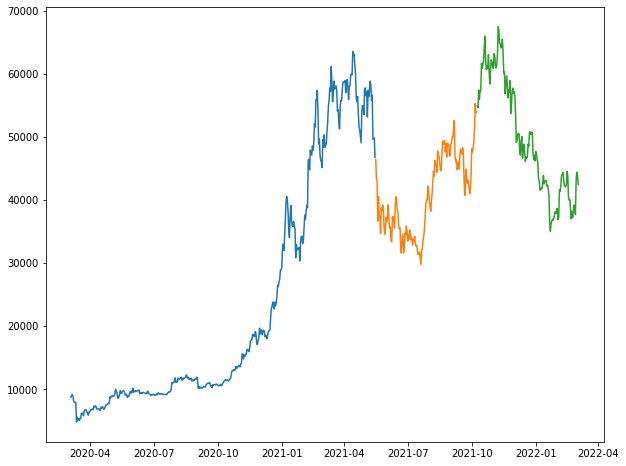

In [103]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(train_time, train['Close'])
plt.plot(cv_time, cv['Close'])
plt.plot(test_time, test['Close'])
plt.show()

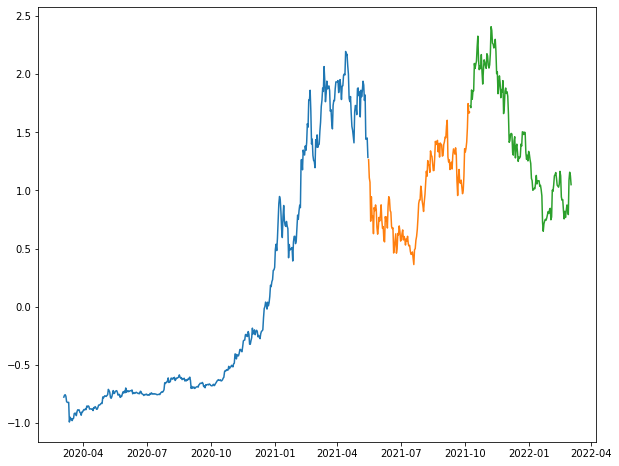

In [104]:
plt.plot(train_time, train_scaled['Close'])
plt.plot(cv_time, cv_scaled['Close'])
plt.plot(test_time, test_scaled['Close'])
plt.show()

## Creating the model

In [105]:
!pip install xgboost

from xgboost import XGBRegressor

In [152]:
# Functions

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):

    model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [153]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [154]:
import math 
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))


RMSE on train set = 29548.137
MAPE on train set = 99.999%


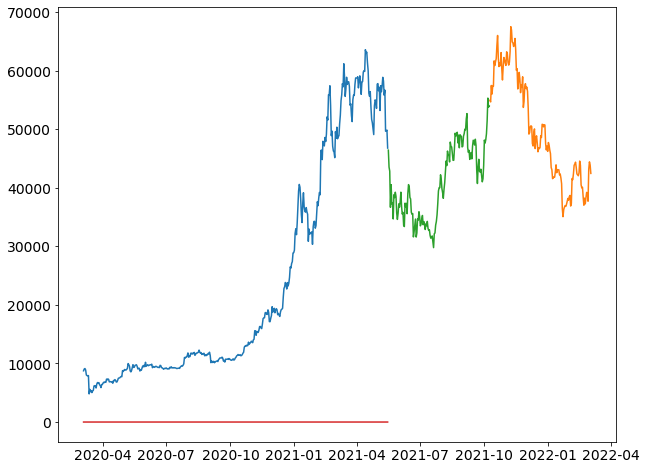

In [155]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       })

plt.plot(train_time,train['Close'])
plt.plot(test_time,test['Close'])
plt.plot(cv_time,cv['Close'])
plt.plot(train_time,est)

In [157]:
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['Close_std'] + cv['Close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 2494.351
MAPE on dev set = 4.676%


/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


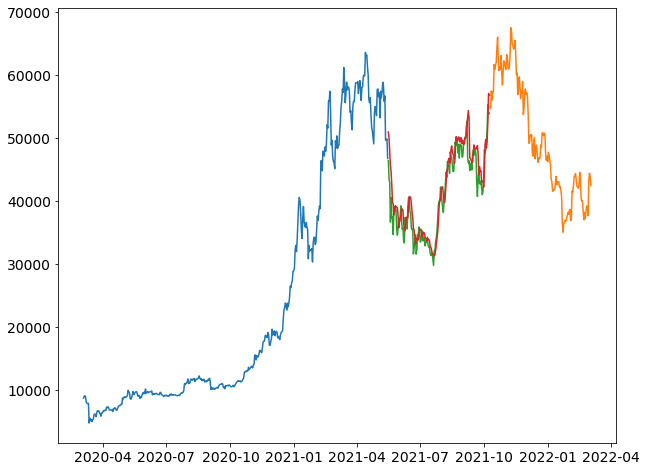

In [158]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       })

plt.plot(train_time,train['Close'])
plt.plot(test_time,test['Close'])
plt.plot(cv_time,cv['Close'])
plt.plot(cv_time,est_df['est'])

In [159]:
imp = list(zip(train[feature_pool], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('Compound', 8.788531e-06),
 ('Bitcoin_SVI', 9.026091e-06),
 ('Transactions', 1.6078244e-05),
 ('Close_std', 2.141165e-05),
 ('FundingRate', 2.2370843e-05),
 ('No. of Unique Addresses', 2.6682812e-05),
 ('Volume', 0.00013623202),
 ('Close_mean', 0.0002445794),
 ('Cryptocurrency_SVI', 0.00076903374),
 ('Close', 0.99873936)]

## Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [161]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic =time()
for param in param_list:
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,n_estimators,max_depth,rmse,mape_pct
0,10,2,2373.374630,4.481739
1,10,3,2365.558967,4.465448
2,10,4,2365.760400,4.465259
3,10,5,2367.487033,4.467938
4,10,6,2367.501669,4.468021
...,...,...,...,...
235,300,5,2495.095734,4.677566
236,300,6,2493.786275,4.675370
237,300,7,2492.576110,4.673152
238,300,8,2492.477354,4.672830


In [162]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2365.559
optimum params = 


(10, 3)

In [125]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 4.465%
optimum params = 


(10, 4)

## Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [126]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in (param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,2231.130135,4.291347
1,0.001,6,2231.130135,4.291347
2,0.001,7,2231.130135,4.291347
3,0.001,8,2231.130135,4.291347
4,0.001,9,2231.130135,4.291347
...,...,...,...,...
107,0.300,16,2474.801651,4.651071
108,0.300,17,2479.215679,4.661426
109,0.300,18,2476.020044,4.650040
110,0.300,19,2472.906005,4.646446


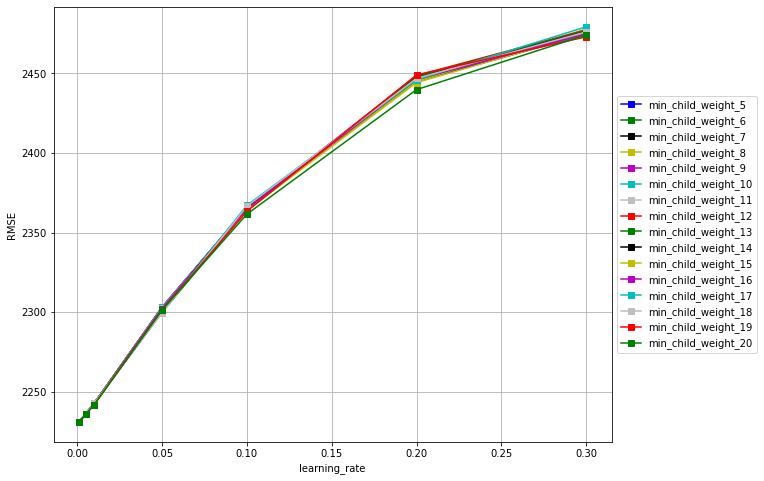

In [127]:
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [128]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2231.033
optimum params = 


(0.001, 20)

In [129]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 4.290%
optimum params = 


(0.005, 5)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [130]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in (param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,2231.479422,4.292898
1,0.1,0.2,2231.479422,4.292898
2,0.1,0.3,2231.479422,4.292898
3,0.1,0.4,2231.479422,4.292898
4,0.1,0.5,2231.479422,4.292898
...,...,...,...,...
95,1.0,0.6,2231.033337,4.291581
96,1.0,0.7,2231.033337,4.291581
97,1.0,0.8,2231.033337,4.291581
98,1.0,0.9,2231.033337,4.291581


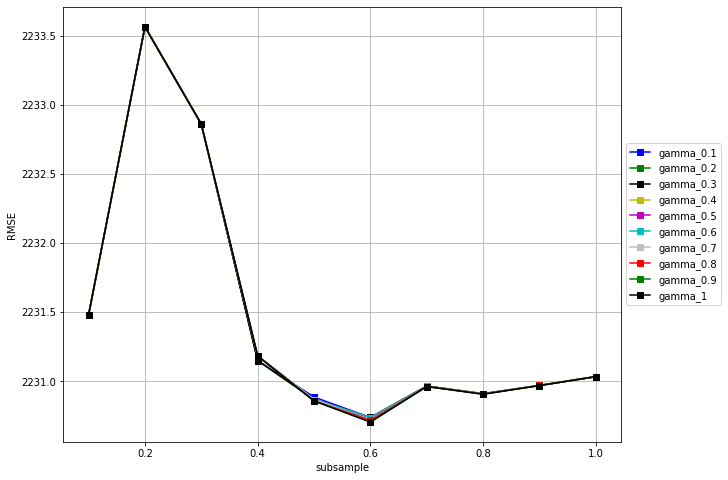

In [131]:
# Plot performance versus params
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [132]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2230.705
optimum params = 


(0.6, 0.9)

In [133]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 4.291%
optimum params = 


(0.6, 0.9)

## Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [134]:


param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in (param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   



/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,2231.895156,4.292807
1,0.5,0.6,2231.743800,4.292402
2,0.5,0.7,2231.743800,4.292402
3,0.5,0.8,2231.496528,4.291905
4,0.5,0.9,2231.496528,4.291905
5,0.5,1.0,2231.422920,4.291857
6,0.6,0.5,2232.538897,4.293261
7,0.6,0.6,2232.538897,4.293261
8,0.6,0.7,2232.344269,4.293226
9,0.6,0.8,2232.344269,4.293226


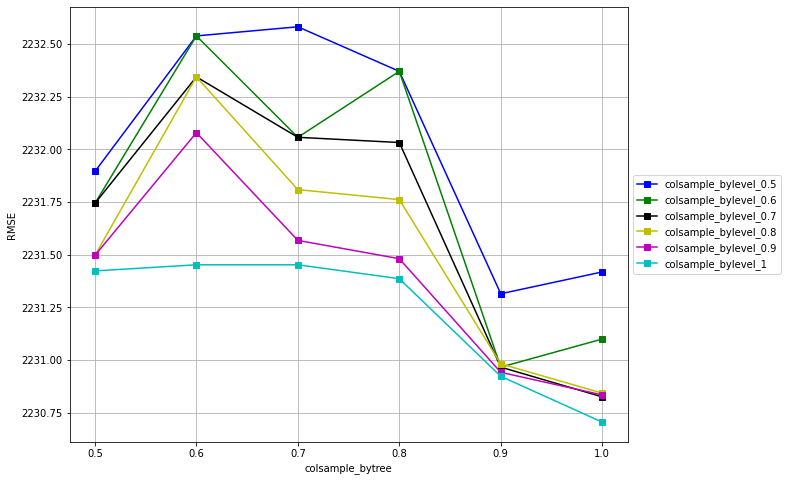

In [135]:
# Plot performance versus params
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [136]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2230.705
optimum params = 


(1.0, 1.0)

In [137]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 4.291%
optimum params = 


(1.0, 1.0)

## Tuned params

In [149]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params
tuned_params

,param,original,after_tuning
0,n_estimators,100.000000,10.000000
1,max_depth,3.000000,3.000000
2,learning_rate,0.100000,0.001000
3,min_child_weight,1.000000,20.000000
4,subsample,1.000000,0.600000
5,colsample_bytree,1.000000,1.000000
6,colsample_bylevel,1.000000,1.000000
7,gamma,0.000000,0.900000
8,rmse,2494.350924,2230.704818
9,mape_pct,4.676275,4.291074


## Final Model

In [150]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['Close_mean'],
                             test['Close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2223.398
MAPE on test set = 3.418%


/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [140]:
# Plot close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                      })

Text(0, 0.5, 'USD')

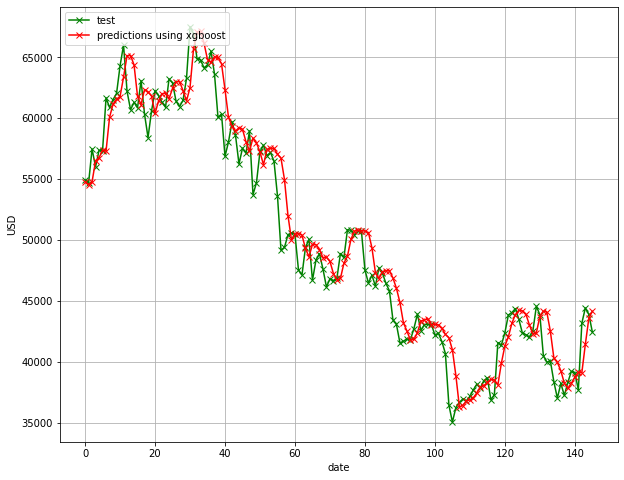

In [141]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = test.plot(y='Close', style='gx-', grid=True)
ax = est_df.plot(y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
#ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
#ax.set_ylim([130, 155])

Text(0, 0.5, 'USD')

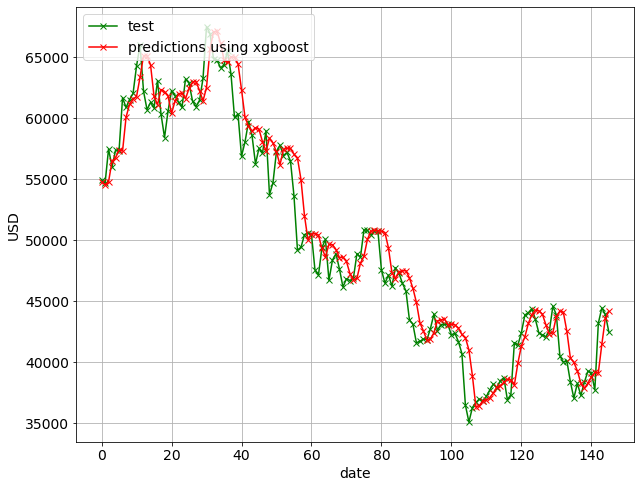

In [148]:
# Plot adjusted close over time, only for test set
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(y='Close', style='gx-', grid=True)
ax = est_df.plot( y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")

#ax.set_ylim([130, 155])

# Identifying Correlations 

In [ ]:
cols = X_train.columns 
corr = X_train[cols].corr()
plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
#returns an array of given shape and type as given array, with zeros
mask = np.zeros_like(corr)

# Return the indices for the upper-triangle of arr and makes it true
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=1.5,annot = True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Export Data

In [ ]:
X_test.to_csv('../data/X_test_scaled.csv', index=False)
X_train.to_csv('../data/X_train_scaled.csv', index=False)
y_train.to_csv('../data/Y_train_scaled.csv', index=False)
y_test.to_csv('../data/Y_test_scaled.csv', index=False)